# Saving Mark Watney: Optimal Spacecraft Trajectory via a Gravity Assist Maneuver # 

#### Connor Wacker (cjwacker@wisc.edu) 
### CS/ECE/ISyE 524 &mdash; Introduction to Optimization &mdash; Spring 2023 ### 
#### Dr. Stephen J. Wright 
https://pages.cs.wisc.edu/~swright/

### May 5, 2023

*****

### Table of Contents

1. [Introduction](#1.-Introduction)
1. [Mathematical Models](#2.-Mathematical-Models)
1. [The Mission](#3.-The-Mission)
1. [Results and Discussion](#4.-Results-and-Discussion)
1. [Conclusion](#5.-Conclusion) 
1. [Citations](#6.-Citations) 
1. [Appendix](#Appendix)

# 1. Introduction #

The objective of our project is to model and optimize the flight path for the mission to rescue Mark Watney in the movie *The Martian*, starring Matt Damon. In the film plot, astronaut Mark Watney is abandoned and presumed dead. However, when his team discovers he is alive, they devise a plan to employ a gravity assist maneuver, using their spacecraft, the Hermes, to orbit Earth and return to Mars. The mission faces challenges due to the unplanned nature, resulting in unfavorable planetary positions for interstellar travel. Therefore, it becomes crucial to save Mark Watney as quickly as possible. One of the solutions depicted in the movie involves the Hermes performing a gravity assist to utilize Earth's gravitational pull and propel itself towards Mars, thereby conserving time and fuel. <br><br>
This project incorporates three models. The first model focuses on plotting the flight path from Mars to Earth. The second model, the gravity assist model, represents the pivotal aspect of the mission, involving the gravity assist maneuver. The gravity assist plays a critical role in fuel conservation, which is severely limited. By capitalizing on Earth's gravitational pull, the spacecraft accelerates and alters its trajectory, enabling it to gain speed with minimal thrust. The last model illustrates the journey to Mars for the purpose of retrieving Mark Watney. All these models aim to minimize thrust usage and, consequently, fuel consumption.
Data for this problem is obtained from the sources listed below, which provide information on the departure and return dates of the Hermes from Mars, as well as the initiation of the gravity assist. We utilized a tool called the New Horizons system from NASA's Jet Propulsion Laboratory, which supplies ephemerides (orbit positions and velocities) for any celestial body within the solar system. By inputting the collected mission dates into this tool, we obtained data points representing the positions of the planets during the specified time interval. <br><br>
The remainder of the project consists of the mathematical models employed to solve the optimization problems. Given the space and gravity factors involved, numerous models are necessary to establish and address the problem. Subsequently, the code implementation section follows, where the models are utilized, and the optimization process is carried out. These models aim to identify the most optimal path, where objectives of each model varies slightly depending on the desired 
<br><br> 

# 2. Definitions and Concepts #
The mission trajectory will consist of the Hermes spacecraft traveling back to Earth, performing a gravity assist maneuver, and traveling back to Mars. The mission begins on November 13, 2035 and ends on **INSERT DATE**. Because the setting takes place in the future, the propulsion system of the Hermes is assumed to be significantly more advanced than any propulsion system invented at the time of this project. For this project, the complete trajectory will be broken up into 3 phases, along with their individual mathematical models: 
* **Phase 1:** Mars to Earth 
* **Phase 2:** Gravity Assist 
* **Phase 3:** Earth to Mars 



The primary optimization software used include open-source packages written in the Julia Programming Language known as *JuMP* and *IPOPT*. The optimization models for each phase are both nonlinear and nonconvex in nature. Therefore, the models will not only be abstract due to nonlinearity, their nonconvex structure also creates many "pseudo-optimal" solutions that may appear to be an optimal solution, but are not the true or global optimal solution. From a visual perspective, the algorithm may begin at a certain high point and work its way down to one of the local minima, however, on the other side of hump may lie an even better solution, as seen in the **Figure 1** below. The complexity of the problem can be attributed to the dynamics of the planets and their gravitational forces, as well as the objective of the individual models. 

In [1]:
# #UNCOMMENT Cell TO INSTALL NECESSARY PACKAGES
# using Pkg; 
# Pkg.add("GR")  
# Pkg.add("CSV"); Pkg.add("DataFrames") 
# Pkg.add("JuMP"); Pkg.add("Ipopt")  
# Pkg.add("Plots") 
# Pkg.add("LinearAlgebra)

In [2]:
using CSV, DataFrames, Ipopt, JuMP, LinearAlgebra, Plots; gr()

Plots.GRBackend()

FIGURE 1


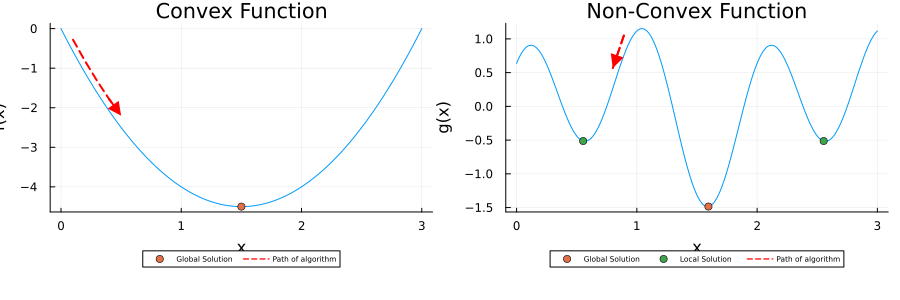

In [3]:
x = 0:0.01:3 
#convex function
f(x) = 2x^2 - 6x 
convexPlot = plot(x, f.(x), label=nothing, xlabel="x", ylabel="f(x)",   #define initial plot
title="Convex Function", legendcolumns=2)  
scatter!(convexPlot,[1.5],[f(1.5)],label="Global Solution")    #function min
plot!(convexPlot, .1:.1:.5,f.(.1:.1:.5).+.3,label="Path of algorithm",linestyle=:dash,     #arrow
      linewidth=2,linecolor=:red,arrow=Plots.Arrow(:closed, :head, 1,1)) 
#nonconvex function
g(x) = .5*sin(π*x -.5) + cos(2π*x -.5)   #function
nc_criticalPoints = [0.5535, 1.5954, 2.5535]   #critical points
localMin = [nc_criticalPoints[1],nc_criticalPoints[3]]   #local min
globalMin = [nc_criticalPoints[2]]        #global min
nonconvexPlot = plot(x, g.(x), label=nothing, xlabel="x", ylabel="g(x)",   #define initial plot
title="Non-Convex Function",legend=:outerbottom,legendcolumns=3) 
scatter!(nonconvexPlot, [globalMin],[g.(globalMin)],label="Global Solution")   #global min
scatter!(nonconvexPlot, [localMin],[g.(localMin)],label="Local Solution")    #local min
plot!(nonconvexPlot, .8:.1:.9,g.(.8:.1:.9).+.3,label="Path of algorithm",linestyle=:dash,   #arrow
      linewidth=2,linecolor=:red,arrow=Plots.Arrow(:closed, :tail, 1,1)) 
println("FIGURE 1")
plot(convexPlot, nonconvexPlot,  layout=(1,2),legend=:outerbottom,legendfontsize=5,size=(900,300))  #plot both plots 

## 2.1 Celestial Mechanics ##
The ephemeris, or positions of each planet, were obtained through NASA's Jet Propulsion Laboratory website. The *Horizons System* tool is open source and provides ephemerides for a variety of celestial bodies. Inner solar system moons and celestial bodies of the outer solar system are excluded from this project for simplicity. The ephemerides are in .csv format containing the X, Y, and Z coordinates in astronomical units (AU) of the planets with respect to the sun. These distances follow a two hour interval from the start of the mission, Sol 1 (Sol 6 in the film), to the end of the mission at Sol 549. **Figure 2** displays the positions of each planet according to the input of the `plot_trajectories()` function, which in this example is set to 365 Sols. 
<br><br> 
The planetary orbits make traversing through the solar system exceptionally difficult due to their force of gravity and velocity. Earth orbits the sun at a speed of 29.8 km/s, meaning that we have to follow the same counterclockwise orbit if we are to travel in between planets. The gravity of each celestial body also affects the trajectory. As the Sun's gravity is 27.9 times the strength of Earth's, the Hermes must maintain a speed and distance from the sun so that it doesn't burn up in its atmosphere. The celestial bodies' curvature of spacetime efficiently represents the varying magnitudes of gravity as shown in **Figure 3**.

In [4]:
#Importing the CSV Files
mercury_raw = DataFrame(CSV.File("mercury_data_acc.csv")) 
venus_raw = DataFrame(CSV.File("venus_data_acc.csv")) 
earth_raw = DataFrame(CSV.File("earth_data_acc.csv")) 
mars_raw = DataFrame(CSV.File("mars_data_acc.csv")) 

mercuryPosition = mercury_raw[:,["X","Y"]]      #extract only the necessary data
venusPosition = venus_raw[:,["X","Y"]] 
earthPosition = earth_raw[:,["X","Y"]]
marsPosition = mars_raw[:,["X","Y"]]
total_days = Int(round(length(marsPosition[:,"Y"])/12));  #12 timesteps in one sol

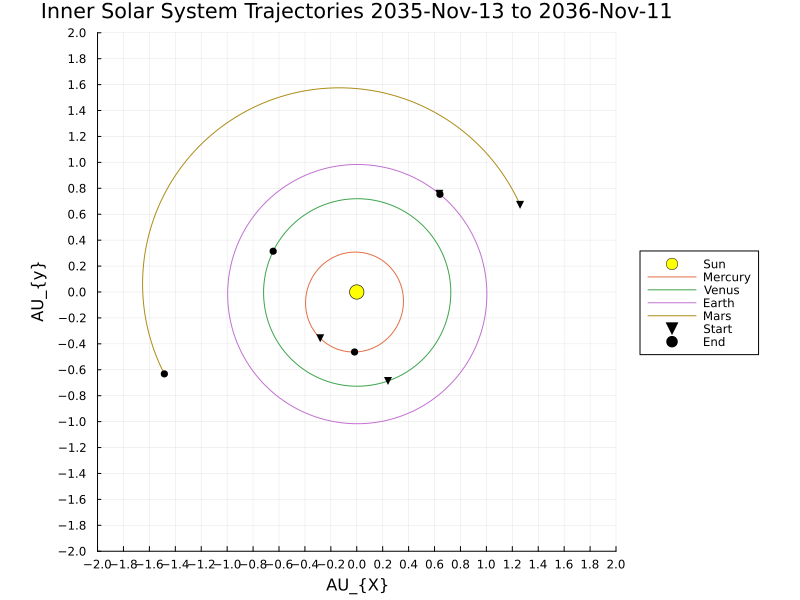

In [5]:
function plot_trajectories(start=1,ending=total_days) #Plots the trajectory of the inner planets

    step = ending*12
    interval = start:step            
    startPosition=cat(Vector(mercuryPosition[start,:]),Vector(venusPosition[start,:]),Vector(earthPosition[start,:]),Vector(marsPosition[start,:]),dims=2)'
    endPosition=cat(Vector(mercuryPosition[step,:]),Vector(venusPosition[step,:]),Vector(earthPosition[step,:]),Vector(marsPosition[step,:]),dims=2)'
    start_date = split(mercury_raw[start,"Calendar Date (TDB)"]," ")[3]
    end_date = split(mercury_raw[step,"Calendar Date (TDB)"]," ")[3]

    scatter([0],[0],mc=:yellow,ms=8,label="Sun",markerstrokewidth = .5)        #plot celestial trajectories
    plot!(mercuryPosition[interval,"X"],mercuryPosition[interval,"Y"],label="Mercury")
    plot!(venusPosition[interval,"X"],venusPosition[interval,"Y"],label="Venus") 
    plot!(earthPosition[interval,"X"],earthPosition[interval,"Y"],label="Earth") 
    plot!(marsPosition[interval,"X"],marsPosition[interval,"Y"],label="Mars") 
    plot!(xticks=-2:.2:2,yticks=-2:.2:2,xlim=[-2,2],ylim=[-2,2],xlabel="AU_{X}",ylabel="AU_{y}")
    
    scatter!(startPosition[:,1],startPosition[:,2],mc=:black,ms=4,markerstrokewidth = .1,label="Start",markershape=:dtriangle) 
    scatter!(endPosition[:,1],endPosition[:,2],mc=:black,ms=4,markerstrokewidth = .1,label="End")
    plot!(legend=:outerright, legendcolumns=1,size=(800,600),aspectratio=:equal)
    title!("Inner Solar System Trajectories $start_date to $end_date")
end 
plot_trajectories(1,365)

**Figure 2**

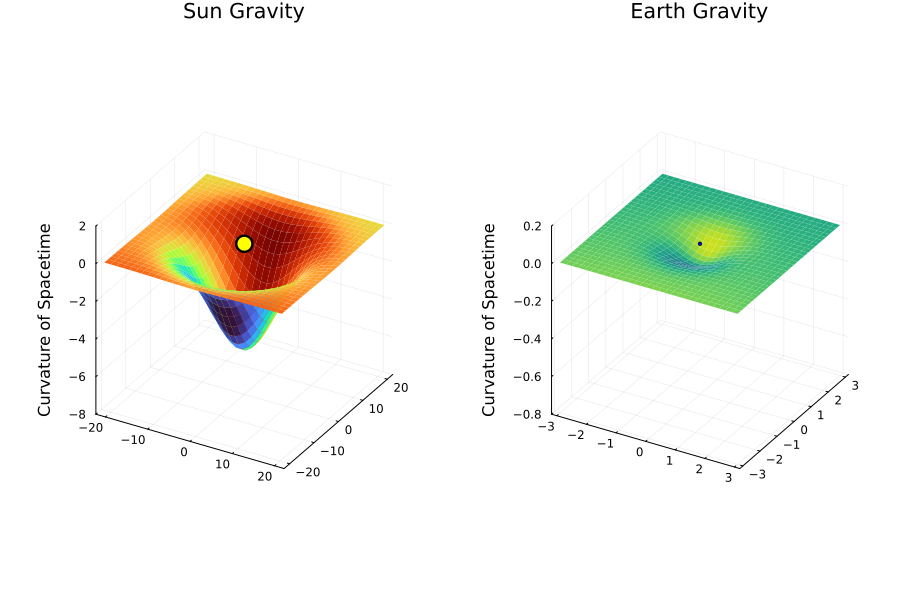

In [6]:
using Plots; gr()

xSun = range(-21, 21, length=30)
sunG = surface(  #:viridis
  xSun, xSun, (xSun, ySun)-> -5.6 * exp(-.01xSun^2 - .01ySun^2), c=:turbo, label="force of gravity", legend=false,
  nx=50, ny=50, display_option=Plots.GR.OPTION_SHADED_MESH, zlims = (-8,2),
)  
scatter!(sunG, [0],[0],[0],ms=9,mc=:yellow,markerstrokewidth=2,label="Sun",legend=:bottomleft,title="Sun Gravity")  
xEarth = range(-3, 3, length=30)
earthG = surface(
  xEarth, xEarth, (xEarth, y)->-.1 * exp(-.9xEarth^2 - .9y^2), c=:viridis, label="force of gravity", legend=false,
  nx=50, ny=50, display_option=Plots.GR.OPTION_SHADED_MESH, zlims = (-.8,.2)
)  
scatter!(earthG, [0],[0],[0],ms=2,mc=:blue,markerstrokewidth=.5,label="Earth",legend=:bottomleft,title="Earth Gravity")  
plot!(earthG, )
plot(sunG, earthG,layout=(1,2),zlabel="Curvature of Spacetime",legend=false,size=(900,600))

**Figure 3:** *Units for the curvature of spacetime are arbitrary in this example. However, the values are proportionate to the masses of the Sun and Earth.*

## 2.2 Spacecraft Dynamics ###
The only independent variable in this problem is the amount of thrust in newtons $N$, denoted as $u$, which the Hermes spacecraft exerts. The complexity of the problem however is attributed to the changing gravitational pull that each of the celestrial bodies exert on the Hermes spacecraft. The gravitational force a celestial body exterts on another object is calculated using the following equation: <br><br>
$$
\begin{aligned}
& \qquad \mathbf{F}_{g} = \frac{GM_{b}m}{r^2} \\ 
\text{Where: } \\
& {F}_{g} \text{ is the gravitational force experienced by the spacecraft in } N \\
& {G} \text{ is the gravitational constant}\\   
& {m} \text{ is the mass of the spacecraft} \\
& {M}_{b} \text{ is the mass of the given celestial body}\\ 
& {r} \text{ is the distance between the spacecraft and the celestial body} \\ 
\end{aligned}  
$$


Using the calculated force of gravity, along with the exerted thrust ($u$), we can calculated the total acceleration of the spacecraft, allowing us to calculate its velocity and its position at each time step. By substituting the net force experienced by the spacecraft, $F_{g} + u$, for $F$ into Newton's 2nd Law $F = ma$, we solve for the acceleration $a$ of the spacecraft at a given time to get $\begin{aligned}\frac{u}{m} - G \sum_{j=1}^k \frac{M_j}{r_j^2} = a\end{aligned}$, where $k$ is the total number of celestial bodies in system. <br> 
Using the equation for final velocity $\mathbf{v}_f = \mathbf{v}_i + \mathbf{a} * \Delta t$ in vector form, we can calculate the final velocity after each time step by substituting the initial velocity of the spacecraft $\mathbf{v}_i$ and our acceleration equation in vector form to get 
$\begin{aligned}\mathbf{v}_{f} = \mathbf{v}_{i} + \left(\frac{\mathbf{u}}{m}  + G \sum_{j=1}^k \frac{M_j*(\mathbf{p}_j - \mathbf{x})}{||\mathbf{p}_{j} - \mathbf{x}||^{2}}\right) * \Delta t, \end{aligned} $ where $\frac{(\mathbf{p}_j - \mathbf{x})}{||\mathbf{p}_j - \mathbf{x}||^{2}}$ is the equivalent of $r_j^2$ in vector form. with $\mathbf{p}_j$ being the position of celestial body $j$ and $\mathbf{x}$ being the initial position of the spacecraft. 

Although thrust is the only independent variable in the model, there are limits as to how the model is allowed to use thrust to meet an optimal trajectory. In accordance to Newton's 1st and 3rd Laws of motion, the spacecraft cannot arbitrarily change its velocity at each timestep using thrust, impulsively stopping and starting to meet its objective. We must therefore implement a function to limit how much the spacecraft can alter its thrust at each timestep. By implementing an $L2 \text{ - Regularization}$ function in the objective, we can create a more uniform usage of thrust, better representing the true conditions of the system. Although the objective functions of each phase will vary, all of them will include the same regulizer $R(x)$, multiplied by the regularization parameter $\lambda$. Say we have an objective to minimize $F(x)$. We would add our regularization components to get $\quad \underset{\mathbf{x}}{\text{min}} \quad F(x) + \lambda R(x)$. The parameter $\lambda$ changes how much we wish to smooth out the thrust with respect to the other objective(s) in $F(x)$. In the objective functions of each phase, $R(x)$ is written as $\begin{aligned}\sum_{i=1}^{n-1} ||\mathbf{u}_{i} - \mathbf{u}_{i+1}||^2\end{aligned}$ where $\mathbf{u}$ is the thrust vector of the Hermes spacecraft.

## 2.3 Demonstration of Concepts ## 
This section combines the principles of celestial mechanics and spacecraft dynamics discussed in the previous sections to demonstrate how the spacecraft trajectory is computed given its objective. For demonstration purposes, the environment will be static, meaning the celestial body will be in a fixed position, and the mass of the probe will be 1kg with a thrust of 0.1 newtons $(N)$. *Figure 4* below displays the starting position of the probe and the desired final position, which lies on the opposite of an imaginary star or planet. The objective is to minimize the distance betweeen the final position and the spacecraft at each timestep,with the mathematical model below *(note the model is written in standard form)*: <br>
$$
\begin{aligned}
\underset{\mathbf{x}_i,\mathbf{v}_i,\mathbf{u}_i \in \mathbb{R^2}}{\text{max}}\qquad& - \sum_{i=1}^{n}(\mathbf{x}_{n} - {x}_{f}) \cdot (\mathbf{x}_{n} - {x}_{f}) - \lambda\sum_{i=1}^{n-1} ||\mathbf{u}_{i} - \mathbf{u}_{i+1}||^2\\\\
\text{subject to:} \qquad
& \mathbf{x}_{i+1} - \mathbf{x}_{i} - dt \cdot \mathbf{v}_{i} = 0 && \forall i \in \{1,\dots,n-1\}\\
& \mathbf{v}_{i+1} - \mathbf{v}_{i} + dt \left(\frac{\mathbf{u}_{i}}{m}  - G \sum_{j=1}^k \frac{M_j(\mathbf{p}_{i}^j - \mathbf{x}_{i})}{||\mathbf{p}_{i}^{j} - \mathbf{x}_{i}||^{2}}  \right) = 0 &&\forall i \in \{1,\dots,n-1\}\\ 
& \mathbf{u}_i\cdot \mathbf{u}_i -T_{max}^2\le 0 && \forall i \in \{1,\dots,n\}\\
& (\mathbf{x}_{n} - \mathbf{x}_{f}) \cdot (\mathbf{x}_{n} - \mathbf{x}_{f}) - d_{max}^2 \le 0\\
& \mathbf{x}_{1} - \mathbf{x}_{init} = 0\\
& \mathbf{v}_{1} - \mathbf{v}_{init} = 0\\
& \text{where:}\\  
& \qquad n \text{ is the number of time steps}\\
& \qquad k \text{ is the number of celestial bodies}\\
& \qquad M_j \text{ is the mass of the j}^{\text{th}}\text{ celestial body (kg)}\\ 
& \qquad \mathbf{r}_{i}^{j} \text{ is the position of celestial body } j \text{ at timestep } i\\
& \qquad \mathbf{x}_{init}, \text{ is the initial position of the probe} \\
& \qquad x_{f} \text{ is the ideal final position of the probe}\\
& \qquad \mathbf{v}_{init} \text{ is the initial velocity of the probe}\\ 
& \qquad dt \text{ is timestep [days]}\\
& \qquad m \text{ is the mass of the probe (kg)}\\
& \qquad G \text{ is the universal gravitational constant } \Bigg(\frac{\text{Newton}\cdot\text{au}^2}{\text{kg}^2}\Bigg)\\
& \qquad T_{max} \text{ is the maximum thrust feasible for the probe}\\ 
\end{aligned} 
$$  
This model can also be used to help estimate the amout of time it takes for the Hermes to travel from one planet to another. The models used are discrete because we cannot minimize time, as we must implement a timestep. By repeatedly solving the model and incrementally decreasing the number of days, we can determine the shortest amount of time before the model is unable to provide a feasible solution. Note that the example below is for demonstration purposes only and that the initial conditions and masses are arbitrary.

In [7]:
function GraphExample(include_trajectory=false)
    x = -1:.1:10; y = -1:.1:10; scaledG = 0.5; sinkPos = [4.5 4.5]; initPos = [.5 8]; finalPos = [7.5 2]
    spaceX = repeat(x', length(y), 1); spaceY = repeat(y, 1, length(x)) 
    W =  (log.((scaledG*(-spaceX .+ sinkPos[1])./((-spaceX .+ sinkPos[1]).^2 .+ (-spaceY .+ sinkPos[2]).^2).^1.5).^2 .+ 
        (scaledG*(-spaceY .+ sinkPos[2])./((-spaceX .+ sinkPos[1]).^2 .+ (-spaceY .+ sinkPos[2]).^2).^1.5).^2))

    sPlot = surface(x, y, -W, levels=50, color=:turbo, display_option=Plots.GR.OPTION_SHADED_MESH, nx=50, ny=50,zlims=(-9,9))
    scatter!(sPlot, [initPos[1]], [initPos[2]], [7],markershape=:circle,markerstrokewidth=1,mc=:white)
    scatter!(sPlot, [finalPos[1]], [finalPos[2]], [7],markershape=:x,markerstrokewidth=2.5,mc=:black,markerstrokecolor=:black) 
    scatter!(sPlot, [sinkPos[1]],[sinkPos[2]],[7],mc=:green,ms=10,markerstrokewidth = 1,label="Earth") 
    plot!(sPlot, size=(900,500),xlabel="X",ylabel="Y",zlabel="Curvature of Spacetime due to Gravity",
    xlim=(0,9),ylim=(0,9),legend=nothing) 

    p = contourf(x, y, -W, levels=70, color=:turbo,linewidth=.05,xlabel="X",ylabel="Y",aspect_ratio=:equal) 
    scatter!(p, [sinkPos[1]],[sinkPos[2]],label="Earth",ms=8,legend=:bottomleft,mc=:green,xlim=(0,9),ylim=(0,9))
    scatter!(p, [initPos[1]], [initPos[2]],label="init pos",markershape=:circle,markerstrokewidth=1,mc=:white)
    scatter!(p, [finalPos[1]], [finalPos[2]],label="final pos",markershape=:x,markerstrokewidth=2.5,mc=:white,markerstrokecolor=:black) 
    
    if include_trajectory==true
        plot!(sPlot, X[:,1], X[:,2], X[:,3],linewidth=1,linecolor=:white,linestyle=:dash) 
        plot!(p, X[:,1], X[:,2], label="Trajactory",lc=:white,linestyle=:dash)  
        gMap = plot(sPlot, p, layout=(1,2),size=(900,400),xguidefontsize=8,yguidefontsize=8,colorbar=false)
        g_Y = sinkMass*G*1*((sinkPos[1] .- X[1:steps,1]).^2 + (sinkPos[2] .- X[1:steps,2]).^2).^-.5 
        F(x) = sqrt.(x[:,1].^2 .+ x[:,2].^2)
        vPlot = plot(collect(1:steps), F(V),label="Velocity"); uPlot = plot(collect(1:steps), F(U),c=:red,label="Thrust",ytickfontsize=4) 
        gPlot = plot(collect(1:steps), g_Y,c=:green,label="Gravitational Force on Object",xlabel="Time",xguidefontsize=8)
        stats = plot(vPlot, uPlot, gPlot, layout=(3,1),legend=:left); l = @layout[a{.6h};b{.4h}] 
        return plot(gMap, stats,layout=l,size=(900,700),legend_background_color=:lightblue1)
    else 
        return plot(sPlot, p, layout=(1,2),size=(900,400),xguidefontsize=8,yguidefontsize=8,colorbar=false,
        legend_background_color=:lightblue1)
    end 
end 
GraphExample(false)

**Figure 4**

In [8]:
G = 2.98e-33
sinkPos = [4.5 4.5]             
sinkMass = 1.99e31 
λ = 100

Tmax = .01         #maximum thrust
maxDist = .01        #Max final distance between final position of probe and objective position    

initPos = [.5 8]          #initial position of probe  
finalPos = [7.5 2]      #final desired position of probe
initV = [0 0]        #initial velocity
 
steps = 46       #time 
m = Model(Ipopt.Optimizer)
set_optimizer_attributes(m, "max_cpu_time" => Float64(30), "max_iter" => 1000, "print_level" => 1)

@variable(m, X[1:steps,1:2])
@variable(m, V[1:steps,1:2])
@variable(m, U[1:steps,1:2]);


In [9]:
    #++++++ DYNAMICS ++++++#
for i in 1:steps-1
    #++++++ CURRENT POS IS PREV. POSITION + PREV. VELOCITY ++++++#
    @constraint(m, X[i+1,:] .== X[i, :] + V[i, :])

    #++++++ CURRENT VELOCITY IS PREV. + THRUST + GRAVITY ++++++# 
    @NLconstraint(m, V[i+1,1] == V[i,1] + U[i,1] + 
        G*sinkMass*(sinkPos[1] - X[i,1])/((sinkPos[1] - X[i,1])^2 + (sinkPos[2] - X[i,2])^2)^1.5) 
    @NLconstraint(m, V[i+1,2] == V[i,2] + U[i,2] + 
        G*sinkMass*(sinkPos[2] - X[i,2])/((sinkPos[1] - X[i,1])^2 + (sinkPos[2] - X[i,2])^2)^1.5) 
end

    #++++++ KEEP THRUST BELOW CERTAIN VALUE ++++++#
@constraint(m, (U[:, 1].^2 + U[:, 2].^2) .<= Tmax^2)

    #++++++ INITIAL CONSTRAINTS FOR SPACECRAFT ++++++# 
@constraint(m, [i in 1:2], X[1, i] == initPos[i])
@constraint(m, [i in 1:2], V[1, i] == initV[i]) 

    #++++++ RENDEZVOUS CONSTRAINTS FOR SPACECRAFT ++++++#
@constraint(m, sum((X[steps, :] - finalPos').^2) <= maxDist^2)

#++++++ REGULARIZE FUEL USAGE + MINIMIZE DISTANCE TO FINAL POSITION ++++++#
@objective(m, Min, λ*sum((U[1:steps-1,1]-U[2:steps,1]).^2 + (U[1:steps-1,2]-U[2:steps,2]).^2)
.+ sum((X[i, j] - finalPos[j])^2 for i in 1:steps, j in 1:2))

optimize!(m) 
println(termination_status(m))

X = hcat(value.(X), zeros(steps) .+ 7)
U = value.(U) 
V = value.(V) 
GraphExample(true)



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

LOCALLY_SOLVED


As observed above, the spacecraft minimizes the distance between itself and the final point for each point in time. Notice how the spacecraft, instead of taking a straight path to minimize distance, has a slightly curved path. This is due to the effect of the celestial body's gravity, where it avoids the gravitational pull so that it isn't thrown off course or pulled too close to escape.

# 3. The Mission #

## 3a. Phase 1: Mars to Earth
In the movie, a scientist named Rich Purnell proposes what is known as a "gravity assist" around earth, where the Hermes spacecraft would use the the Earth's gravity to slingshot itself back towards Mars, increasing the magnitude of velocity and redirecting it in the correct direction. This maneuver and its associated model is very complicated to solve, requiring a great enough final velocity and an approach from the right angle.
<br><br>
The first phase of the gravity assist is the approach. Due to the non-convexity of the model, we require the use of metaheuristics to help determine a feasible solution. Using an interpolation equation:
<br><br>
$$ 
\begin{aligned}  
&
\large
\mathbf{x}_{i}^{\text{est.}} = (1-\frac{i}{n})*\mathbf{x}_{i}^{\text{start}} + \frac{i}{n}*\mathbf{x}_{i}^{\text{dest}} + \mathbf{C} \qquad \forall i \in {1,\dots,n}\\   
& \text{where:}\\
& \qquad \mathbf{C} \text{ represents an offset for the planet's initial position from Mars}\\ 
\end{aligned}
$$
<br>

**Mathematical Model:**
$$
\begin{aligned}
\underset{\mathbf{x}_i,\mathbf{v}_i,\mathbf{u}_i \in \mathbb{R^2}}{\text{max}}\qquad& -\sum_{i=1}^{n}\mathbf{u}_i\cdot \mathbf{u}_i - \lambda\sum_{i=1}^{n-1} ||\mathbf{u}_{i} - \mathbf{u}_{i+1}||^2 + \mu\mathbf{v}_f\\
\text{subject to:} \qquad
& \mathbf{x}_{i+1} - \mathbf{x}_{i} - dt \cdot \mathbf{v}_{i} = 0 && \forall i \in \{1,\dots,n-1\}\\
& \mathbf{v}_{i+1} - \mathbf{v}_{i} + dt * \alpha \left(\frac{\mathbf{u}_{i}}{m}  - G \sum_{j=1}^k \frac{M_j}{||\mathbf{p}_{i}^{j} - \mathbf{x}_{i}||^{2}} \right) = 0 &&\forall i \in \{1,\dots,n-1\}\\ 
& \mathbf{u}_i\cdot \mathbf{u}_i -T_{max}^2\le 0 && \forall i \in \{1,\dots,n\}\\
& (\mathbf{x}_{n} - \mathbf{x}_{f}) \cdot (\mathbf{x}_{n} - \mathbf{x}_{f}) - d_{max}^2 \le 0\\
& \mathbf{x}_{1} - \mathbf{x}_{init} = 0\\
& \mathbf{v}_{1} - \mathbf{v}_{init} = 0\\ 
& \text{where:}\\  
& \qquad n \text{ is the number of time steps}\\
& \qquad k \text{ is the number of celestial bodies}\\
& \qquad M_j \text{ is the mass of the j}^{\text{th}}\text{ celestial body (kg)}\\ 
& \qquad \mathbf{p}_{i}^{j} \text{ is the position of celestial body } j \text{ at timestep } i\\
& \qquad \mathbf{x}_{init}, \text{ is the initial position of the Hermes} \\
& \qquad \mathbf{x}_{f} \text{ is the initial and ideal final position of the Hermes}\\
& \qquad \mathbf{v}_{init} \text{ is the initial velocity of the probe}\\ 
& \qquad dt \text{ is timestep [days]}\\
& \qquad \alpha \text{ is the acceleration conversion (from } \frac{\text{m}}{\text{s}^2} \text{ to } \frac{\text{au}}{\text{day}^2} \text{)}\\
& \qquad m \text{ is the mass of the probe (kg)}\\
& \qquad G \text{ is the universal gravitational constant } \Bigg(\frac{\text{Newton}\cdot\text{au}^2}{\text{kg}^2}\Bigg)\\
& \qquad T_{max} \text{ is the maximum thrust feasible for the Hermes (N)}\\ 
& \qquad \mathbf{x}_{f} \text{ is the final velocity of the Hermes in the }x \text{ direction}  \\
& \qquad \lambda ,\mu \text{ are weights for the objectives}
\end{aligned} 
$$ 
<br><br> 


The objective for phase 1 is to minimize thrust while implementing the $L2$ normalization as the booster cannot perform arbitrary bursts. The objective also includes a final velocity maximizing factor as the Hermes must approach the Earth at a great enough speed in order to be able to perform a gravity assist. 

In [10]:
function GraphPhase(trajectory, plot_title, start=startSol,step=phaseTotal,phase1::Bool=true)  #graphs the phase trajectory
      interval = start:step
      startPosit=cat(Vector(mercuryData[start,:]),Vector(venusData[start,:]),Vector(earthData[start,:]),Vector(marsData[start,:]),dims=2)
      endPosit=cat(Vector(mercuryData[step,:]),Vector(venusData[step,:]),Vector(earthData[step,:]),Vector(marsData[step,:]),dims=2)
 
      X = scatter([sunPos[1]],[sunPos[2]],mc=:yellow,ms=8,label=nothing,markerstrokewidth = .5)  
      xaxis = Plots.get_axis(Plots.get_subplot(X,1),:x); xaxis[:gridalpha] = 0.7
      yaxis = Plots.get_axis(Plots.get_subplot(X,1),:y); yaxis[:gridalpha] = 0.7
      xaxis[:foreground_color_grid] = colorant"white"
      yaxis[:foreground_color_grid] = colorant"white"
      plot!(X, mercuryData[interval,1],mercuryData[interval,2],label="Mercury",linecolor=:grey)
      plot!(X, venusData[interval,1],venusData[interval,2],label="Venus",linecolor=:lightpink) 
      plot!(X, earthData[interval,1],earthData[interval,2],label="Earth",linecolor=:green) 
      plot!(X, marsData[interval,1],marsData[interval,2],label="Mars",linecolor=:red) 
      plot!(trajectory[1,:],trajectory[2,:],label="hermes trajectory",linestyle=:dash,linewidth=1.5,linecolor=:yellow)  
      plot!(X, xticks=-2:.2:2,yticks=-2:.2:2,xlim=[-2,2],ylim=[-2,2],xlabel="AU_x",ylabel="AU_y")  
      if phase1==true 
            plot!(X, initLinearPos[1,:],initLinearPos[2,:],label="est. trajectory",linestyle=:dash,linecolor=:lightblue1) 
      else 
            plot!(X, initLinearPos3[1,:],initLinearPos3[2,:],label="est. trajectory",linestyle=:dash,linecolor=:lightblue1) 
      end
      scatter!(X, startPosit[1,:],startPosit[2,:],mc=:white,ms=4,markerstrokewidth = .1,label="Start")
      scatter!(X, endPosit[1,:],endPosit[2,:],mc=:white,ms=4,markerstrokewidth = .1,markershape=:dtriangle,label="End") 
      plot!(X, markerstrokecolor=:white,legendfontcolor=:white, legend=:outerright,size=(800,600),aspect_ratio=:equal, 
      background_color=:black,background_color_outside=:white,title=plot_title)   
 end 
 
function CloseUp(xPhase,planet,start,step,graphRange=.0007) #provides a close up of the approach
      interval = start:step
      if planet == "Earth"  
            planetX = earthData[interval,:]
            planetPos = earthData[step,:]  
            c = :green; sol = step
      elseif planet == "Mars" 
            planetX = marsData3[1:323,:]
            planetPos = marsData3[323,:]
            c = :red; sol = 548
      else 
            return "planet not available"
      end 
      magX = plot(planetX[:,1],planetX[:,2],label=nothing,linecolor=c)
      xaxis = Plots.get_axis(Plots.get_subplot(magX,1),:x); xaxis[:gridalpha] = 0.7
      yaxis = Plots.get_axis(Plots.get_subplot(magX,1),:y); yaxis[:gridalpha] = 0.7
      xaxis[:foreground_color_grid] = colorant"white"
      yaxis[:foreground_color_grid] = colorant"white" 
      plot!(magX, xlim=(planetPos[1]-graphRange,planetPos[1]+graphRange),ylim=(planetPos[2]-graphRange,planetPos[2]+graphRange),
      xlabel="AU_x",ylabel="AU_y")  
      plot!(magX, xPhase[1,:],xPhase[2,:],label=nothing,linestyle=:dash,linecolor=:yellow)  
      scatter!(magX, [planetPos[1]],[planetPos[2]],label=planet,mc=c,markersize=10,markerstrokecolor=:white)    
      scatter!(magX, [xPhase[1,end]], [xPhase[2,end]],label="Hermes",mc=:yellow)
      plot(magX,title="Sol $sol Position",legendfontcolor=:white, legend=:topright,
      background_color=:black,background_color_outside=:white) 
end 


function GetMetrics(phaseX, phaseV, phaseU)  #Graphs the metrics of the Phase
      velocity = collect(value.(phaseV))
      total_velocity = Vector()
      for i in 1:length(velocity[1,:])
          tv = (velocity[1,i]^2 + velocity[2,i]^2)^.5
          append!(total_velocity,tv) 
      end
      V = plot(velocity[1,:],label="V_{x}",xlabel="Sols",ylabel="magnitude (AU/Sol)",title="Velocity (V)")
      plot!(V, velocity[2,:],label="V_{y}",xlim=(0,step+1),xticks=0:20:step+1) 
      plot!(V, total_velocity,label="||V||",linewidth=2)  
      
  
      thrust = collect(value.(phaseU))
      total_thrust = Vector()
      for i in 1:length(thrust[1,:])
          tt = (thrust[1,i]^2 + thrust[2,i]^2)^.5
          append!(total_thrust,tt) 
      end
      U = plot(thrust[1,:],label="U_{x}",xlabel="Sols",ylabel="magnitude (N)",title="Thrust (U)")
      plot!(U, thrust[2,:],label="U_{y}",xlim=(0,step+1),xticks=0:20:step+1) 
      plot!(U, total_thrust,label="||V||",linewidth=2)   
  
      x = collect(value.(phaseX))
      X = plot(collect(1:step)*dt,
      (earthMass*hermesMass*G*1*((-x[1,:] + earthData[startSol:phaseTotal,1]).^2 + (-x[2,:] + earthData[startSol:phaseTotal,2]).^2).^-.5),
      yscale=:log10,label="Earth")
      plot!(collect(1:step)*dt,
      (marsMass*hermesMass*G*1*((-x[1,:] + marsData[startSol:phaseTotal,1]).^2 + (-x[2,:] + marsData[startSol:phaseTotal,2]).^2).^-.5),
      yscale=:log10,label="Mars")
      plot!(collect(1:step)*dt,
      (mercuryMass*hermesMass*G*1*((-x[1,:] + mercuryData[startSol:phaseTotal,1]).^2 + (-x[2,:] + mercuryData[startSol:phaseTotal,2]).^2).^-.5),
      yscale=:log10,label="Mercury")
      plot!(collect(1:step)*dt,
      (venusMass*hermesMass*G*1*((-x[1,:] + venusData[startSol:phaseTotal,1]).^2 + (-x[2,:] + venusData[startSol:phaseTotal,2]).^2).^-.5),
      yscale=:log10,label="Venus")
      plot!(X, collect(1:step)*dt,
      (sunMass*hermesMass*G*1*((sunPos[1] .- x[1,1:step]).^2 + (sunPos[2] .- x[2,1:step]).^2).^-.5),
      yscale=:log10,label="Sun")
      plot!(X, yticks=yticks=10 .^ (-8.:2:8),legend=:topleft,
        ylabel="Newtons",xlabel="Sols",title="Gravity felt by the Hermes (N)",size=(1000,500), 
        xlim=(0,step+1),xticks=0:20:step+1)
  
      return plot(V, U, X, layout=(3,1), legend=:outerright,size=(900, 700))
  end 

GetMetrics (generic function with 1 method)

In [11]:
startSol = 1 
interV = 12   #data interval (original data intervals (2hrs) was too many for the model)
dt = interV/12 #timestep

mercuryPosition = mercury_raw[1:interV:end,["X","Y"]]
venusPosition = venus_raw[1:interV:end,["X","Y"]] 
earthPosition = earth_raw[1:interV:end,["X","Y"]]
marsPosition = mars_raw[1:interV:end,["X","Y"]] 

#++++++ MASSES IN KG ++++++#
sunMass = 1.99e30
mercuryMass = 3.30e23
venusMass = 4.87e24
earthMass = 5.97e24
marsMass = 6.42e23
hermesMass = 1.1e5

#++++++ MISC PARAMETERS ++++++#
sunPos = [0, 0]         
G = 2.98e-33       # Gravitational constant in units of newtons*AU^2/Kg^2
Tmax = 220  # converts M/s^2 to AU/day^2 
minSun = 0.23396054928 #cannot come too close to sun   
maxSun = 1.5 #cannot leave inner solar system
marsInitV = [-6.054626969549614e-03,  1.354296174136115e-02] #mars initial velocity 
α = .0499 #acceleration conversion from m/s^2 to AU/DAY^2
earthEndV = [1.691516474390618e-02,  7.095973379846021e-04] #earth final velocity

#++++++ ADJUSTABLE PARAMETERS ++++++#
PhaseLength = 225 # how long journey takes in days (manually adjusted)  
phaseTotal = startSol + PhaseLength - 1 
λ = 100 
μ = 10

step = Int64(round(PhaseLength/dt))   # time step

#++++++ CONVERT DATAFRAME TO MATRIX FOR FASTER COMPUTATION ++++++#
mercuryData = Matrix(mercuryPosition[:,1:2])
venusData = Matrix(venusPosition[:,1:2])
earthData = Matrix(earthPosition[:,1:2])
marsData = Matrix(marsPosition[:,1:2])

startData = marsData
destData = earthData
;

In [12]:
m = Model(Ipopt.Optimizer)  

set_optimizer_attributes(m, "print_level" => 3, "max_iter" => 8000)

#***** DEFINE VARIABLES FOR PROBE POSITIONS, VELOCITIES, AND THRUSTS *****#
@variable(m, HX[1:2,1:step])
@variable(m, HV[1:2,1:step])
@variable(m, HU[1:2,1:step])

#***** DEFINING ESTIMATED LINEAR TRAJECTORY *****#
offSet = ones(2,1)*.005
initLinearPos = zeros(2,step)
initLinearVel = zeros(2,step)

for i in 1:step
    factor = i/step
    initLinearPos[:,i] = (marsData[i,1:2]'.*(1-factor)+earthData[i,1:2]'.*factor .+ offSet')
end
for i in 1:step-1
    initLinearVel[:,i] = (initLinearPos[:,i+1]-initLinearPos[:,i])*dt
end

#++++++ ASSIGN VALUEs TO VARIABLES ++++++#
for i in 1:2 
    for j in 1:step
        set_start_value(HX[i,j], initLinearPos[i,j])
        set_start_value(HV[i,j], initLinearVel[i,j]) 
    end
end;

**NOTE: Solves at around 2 min. with a robust processor, longer otherwise**

In [13]:
for i in 1:step-1
    #++++++ CURRENT POS IS PREV. POSITION + PREV. VELOCITY ++++++#
    @constraint(m, HX[:,i+1] .== HX[:,i] + dt*HV[:,i])
    
    #++++++ CURRENT VELOCITY IS PREV. + THRUST + GRAVITY ++++++#
    @NLconstraint(m, HV[1,i+1] == HV[1,i] + dt*α*(HU[1,i]/hermesMass + 
        sunMass*G*(sunPos[1] - HX[1,i])/((HX[1,i] - sunPos[1])^2 + (HX[2,i] - sunPos[2])^2)^1.5 +
        mercuryMass*G*(mercuryData[i,1] - HX[1,i])/((HX[1,i] - mercuryData[i,1])^2 + 
            (HX[2,i] - mercuryData[i,2])^2)^1.5 +
        venusMass*G*(venusData[i,1] - HX[1,i])/((HX[1,i] - venusData[i,1])^2 + (HX[2,i] - venusData[i,2])^2)^1.5 +
        earthMass*G*(earthData[i,1] - HX[1,i])/((HX[1,i] - earthData[i,1])^2 + (HX[2,i] - earthData[i,2])^2)^1.5 +
        marsMass*G*(marsData[i,1] - HX[1,i])/((HX[1,i] - marsData[i,1])^2 + (HX[2,i] - marsData[i,2])^2)^1.5))# +
    @NLconstraint(m, HV[2,i+1] == HV[2,i] + dt*α*(HU[2,i]/hermesMass + 
        sunMass*G*(sunPos[2] - HX[2,i])/((HX[1,i] - sunPos[1])^2 + (HX[2,i] - sunPos[2])^2)^1.5 + 
        mercuryMass*G*(mercuryData[i,2] - HX[2,i])/((HX[1,i] - mercuryData[i,1])^2 + 
            (HX[2,i] - mercuryData[i,2])^2)^1.5 + 
        venusMass*G*(venusData[i,2] - HX[2,i])/((HX[1,i] - venusData[i,1])^2 + (HX[2,i] - venusData[i,2])^2)^1.5 +
        earthMass*G*(earthData[i,2] - HX[2,i])/((HX[1,i] - earthData[i,1])^2 + (HX[2,i] - earthData[i,2])^2)^1.5 +
        marsMass*G*(marsData[i,2] - HX[2,i])/((HX[1,i] - marsData[i,1])^2 + (HX[2,i] - marsData[i,2])^2)^1.5))
end

#++++++ KEEP THRUST BELOW CERTAIN VALUE ++++++#
@constraint(m, Tmax .<= (HU[1,:].^2+HU[2,:].^2) .<= Tmax^2)

#++++++ INITIAL CONSTRAINTS FOR HERMES ++++++#
@constraint(m, HX[:,1] .== [startData[1,1] - .005, startData[1,2]])
@constraint(m, HV[:,1] .== marsInitV[:])   

#++++++ RENDEZVOUS CONSTRAINTS FOR HERMES ++++++#
@constraint(m, (HX[1, step]-destData[step, 1])^2 + (HX[2, step]-destData[step,2])^2 <= .0005^2) 
@constraint(m, (HX[1, step] <= destData[step, 1])) 
@constraint(m, (HX[2, step] <= destData[step,2])) 

#++++++ MIN DISTANCE FROM SUN ++++++# 
@constraint(m, HX[1,:].^2 + HX[2,:].^2 .>= minSun^2) 

#++++++ VELOCITY APPROACH ANGLE MUST NOT BE TOO GREAT +++++#
@constraint(m, HV[2,step] >= earthEndV[2] - .004) 
@constraint(m, HV[1,step] >= earthEndV[1] + .001)

#++++++ CANNOT LEAVE INNER SOLAR SYSTEM ++++++#
@constraint(m,-maxSun .<= HX .<= maxSun)
@objective(m, Min, λ*sum((HU[1,1:step-1]-HU[1,2:step]).^2 + (HU[2,1:step-1]-HU[2,2:step]).^2) +
    sum((HU[1,:].^2 + HU[2,:].^2)) - μ*(HV[1,step])) 

    
@time(optimize!(m))   
#solve_time()
println() 
println(termination_status(m))

Total number of variables............................:     1350
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      900
Total number of inequality constraints...............:     1580
        inequality constraints with only lower bounds:      902
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      678


Number of Iterations....: 1891

                                   (scaled)                 (unscaled)
Objective...............:   5.0298077792539205e+06    5.0298077792539205e+06
Dual infeasibility......:   5.8114528656005859e-07    5.8114528656005859e-07
Constraint violation....:   1.9428902930940239e-16    1.9428902930940239e-16
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementa

**Phase 1 Results:**

In [14]:
#++++++ CAPTURE VALUES ++++++#
xPhase1 = value.(HX)
vPhase1 = value.(HV)
uPhase1 = value.(HU) 
xEnd1 = xPhase1[:,step] 
#HX0 = earthData[step,:] - [.000007,.000007] #assumed Hermes phase 1 final position for gravity assist
vEnd1 = vPhase1[:,step]
uEnd1 = uPhase1[:,step] 
earthVel = earthData[step,:] - earthData[step-1,:]; #earth final velocity phase 1 
finalV_km = sqrt(vEnd1[1]^2 + vEnd1[2]^2) * 1731.46 
earthPos = earthData[step,:]
println("Hermes Phase 1 final position relative to the sun (AU): ",round.(xEnd1,digits=3)) 
println("Hermes Phase 1 final velocity (AU/days): ",round.(vEnd1,digits=3)) 
println("Hermes Phase 1 final thrust (N): ",round.(uEnd1,digits=3))  
println()
println("Earth approach speed of Hermes: ", round.(finalV_km,digits=3), " km/s") 

Hermes Phase 1 final position relative to the sun (AU): [0.045, -1.015]
Hermes Phase 1 final velocity (AU/days): [0.018, -0.003]
Hermes Phase 1 final thrust (N): [94.368, 175.435]

Earth approach speed of Hermes: 31.538 km/s


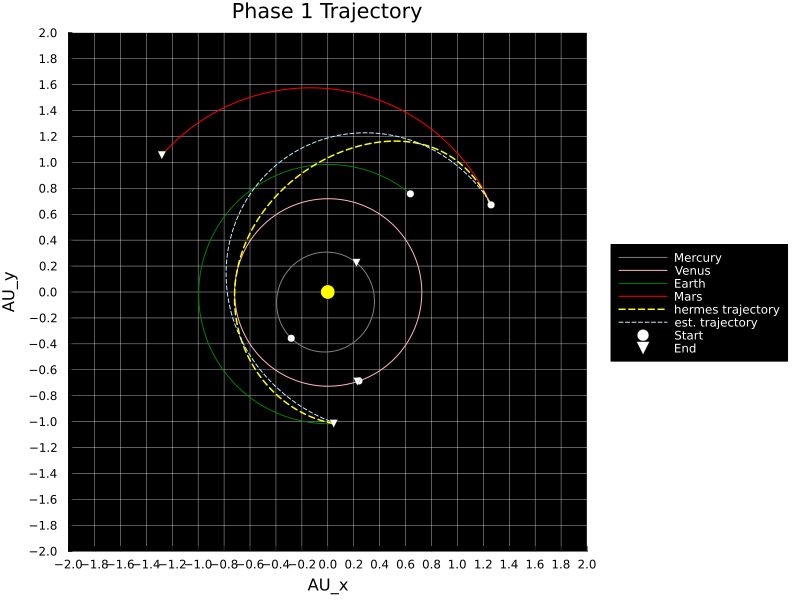

In [15]:
GraphPhase(xPhase1, "Phase 1 Trajectory")

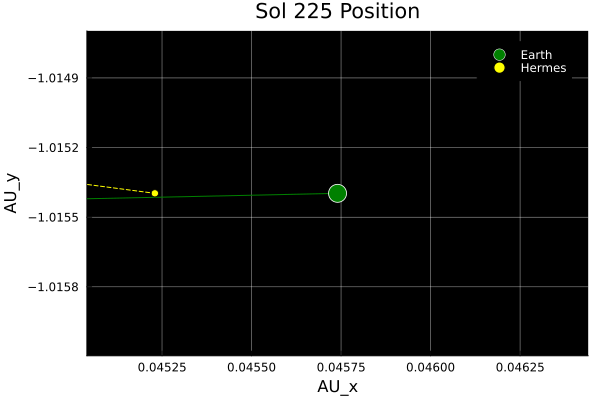

In [16]:
CloseUp(xPhase1,"Earth",1,225,.0007)

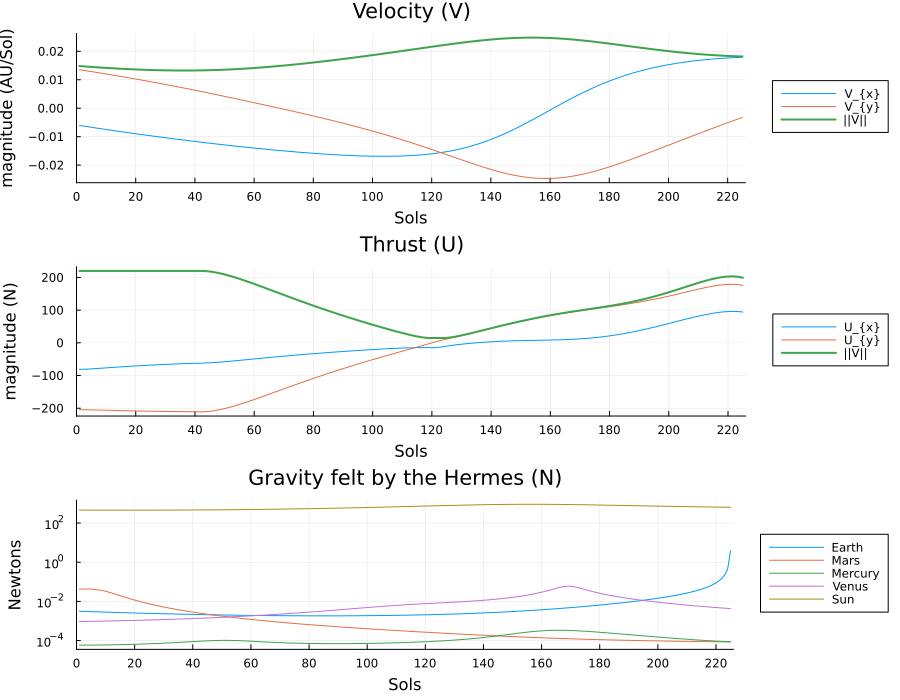

In [17]:
GetMetrics(xPhase1,vPhase1,uPhase1)

## 3b. Phase 2: Gravity Assist
Unfortunately we are unable to implement the gravity assist within an optimization model given the software available. Methods such as implementing waypoints, presolving the model using a linear trajectory around the earth, and implementing differential equations to optimize the trajectory and minimize the resulting time result in too many points of infeasibility as the dynamics are too complicated for the *Ipopt* library in Julia. We therefore implement a standard gravity assist formulation, using the initial conditions from phase 1 to calculate the final position and velocity of the Hermes, which are then used as the initial conditions in the phase 3 model. 
<br><br>
$$
\begin{aligned} 
\large
\vec{v}_{final} = \vec{v}_{init}R(\alpha) + \Delta\vec{v} + \frac{u}{m}t_{CA} \\ 
\large
\vec{x}_{final} = \vec{x}_{init} + \vec{v}_{final} \\ 
\end{aligned}
$$ 

<br>

$$
\begin{aligned}
& \text{where:} \\
&\qquad \vec{v}_{final} \text{ is final velocity vector of the spacecraft} \\
&\qquad \vec{v}_{start} \text{ is initial velocity vector of the spacecraft} \\
&\qquad R(\alpha) \text{ is the rotation matrix that rotates the initial velocity vector by an angle } \alpha \\
&\qquad \alpha \text{ is the angle of rotation (in degrees)} \\
&\qquad \Delta\vec{v} \text{ is change in velocity vector due to the gravity assist} \\
&\qquad u \text{ is thrust} \\
&\qquad m \text{ is mass of the spacecraft} \\
&\qquad t_{CA} \text{ is time of closest approach to the planet} \\ 
\end{aligned}
$$  
Since the goal of the gravity assist is to increase speed while changing the angle of velocity as much as possible, we tweak the angle of rotation until we find an angle which is most optimal given the computational constraints. Ideally, this would be finding an angle which gives us the greatest velocity in the Y direction while maintaining a positive velocity in the X direction. The function below takes one argument, the angular change in velocity, and returns a variety of metrics and sets them to corresponding variables. For this portion, we were forced to guess and check which angle gives us a satisfying solution, which ideally is a total increase in velocity and the greatest increase being in the y-direction, with x and y velocity being positive values.

In [18]:
function GravityAssist(angleDeg) 
    angleRad = angleDeg / 180 * pi # Convert angle to radians
    R = [cos(angleRad) -sin(angleRad); sin(angleRad) cos(angleRad)] 
    gaStartVelR = R * vEnd1  #rotate inital HV by desired angle

    relVel = gaStartVelR - earthVel # Calculate relative velocity between Hermes and Earth
    tCA = -dot(relVel, earthPos - xEnd1) / dot(relVel, relVel) # Calculate time of closest approach to Earth

    #++++++ CALC. RELATIVE V AND X @ CLOSEST APPROACH TO EARTH ++++++#
    gaStartPosCA = xEnd1 + gaStartVelR * tCA
    earthPosCA = earthPos + earthVel * tCA
    relPosCA = gaStartPosCA - earthPosCA
    relVelCA = relVel

    # Calculate ΔV due to gravity assist
    ΔV = -2 * dot(relVelCA, relPosCA) / norm(relPosCA)^2 * relPosCA 

    # Calculate final velocity vector of spacecraft
    gaEndVel = gaStartVelR + ΔV + uEnd1 / hermesMass * tCA 

    
    distanceTraveled = norm(gaStartPosCA - xEnd1) #total distance traveled by hermes during gravity assist
    t = distanceTraveled / norm(ΔV)    #total time of gravity assist in days
    gaEndPos = xEnd1 + gaEndVel * t #Hermes end position

# Print time of maneuver
    println("Time of maneuver (min): ", round(t * 1440,digits=3))
    println("Time of maneuver (DAYS): ", round(t, digits=6))
    println("Hermes Final Position (AU): ", round.(gaEndPos,digits=6))
    println("Hermes Final velocity (AU/DAYS): ", round.(gaEndVel,digits=6))   
    println() 
    println("Hermes entering speed: ", round.(finalV_km,digits=3), " km/s") 
    println("Hermes exiting speed: ", round(sqrt(gaEndVel[1]^2 + gaEndVel[2]^2)*1731.46,digits=3)," km/s")
    return gaEndPos, gaEndVel
end

GravityAssist (generic function with 1 method)

In [19]:
println("Spacecraft initial position relative to the sun (AU): ",round.(xEnd1,digits=3)) 
println("Spacecraft initial velocity (AU/days): ",round.(vEnd1,digits=3))  
println()
angleDeg = 49   #hyperparameter representing the angular change in velocity
gaEndPos, gaEndVel = GravityAssist(angleDeg);

Spacecraft initial position relative to the sun (AU): [0.045, -1.015]
Spacecraft initial velocity (AU/days): [0.018, -0.003]

Time of maneuver (min): 29.298
Time of maneuver (DAYS): 0.020346
Hermes Final Position (AU): [0.045717, -1.015209]
Hermes Final velocity (AU/DAYS): [0.023919, 0.009239]

Hermes entering speed: 31.538 km/s
Hermes exiting speed: 44.397 km/s


## 3c. Phase 3: Earth to Mars 
Phase 3 consists of traveling from earth back to mars. Due to the ill-positioned planets, phase 3 is the longest leg of the mission, spanning 325 Sols in the movie. Due to the planets' positions, using the same linear interpolation equation seen in *phase 1* is not feasible as the planets are not on opposite sides of the solar system, i.e the path would take the Hermes through the Sun. We therefore need to slightly modify the interpolation by making it nonlinear to change the path. <br>  
$$  
\begin{aligned} 
&\begingroup 
\large
\mathbf{x}_{i}^{\text{est.}} = \Bigg(1- \left(\frac{i}{n}\right)^\beta\Bigg)*\mathbf{x}_{i}^{\text{start}} + \left(\frac{i}{n}\right)^\beta*\mathbf{x}_{i}^{\text{dest}} + \mathbf{C} \qquad \forall i \in {1,\dots,n}\\ 
\endgroup \\
&\text{where:}\\
& \qquad \mathbf{C} \text{ is an offset for the planet's initial position from Mars}\\  
& \qquad \beta \text{ is the scaling factor of the path} \\   
\end{aligned} 
$$ 
<br><br>
$$ 
\begin{aligned}
&\begingroup 
\large
\mathbf{v}_{i}^{\text{est.}} = dt*\left(\mathbf{x}_{i+1}^{\text{est.}} - \mathbf{x}_{i}^{\text{est.}}\right) \qquad \forall i \in {1,\dots,n-1}\\ 
\endgroup\\
&\text{where:}\\
& \qquad dt \text{ is time step [days]}\\ 
\end{aligned} 
$$
<br><br>

The objective is also different from that of phase 1. Because Mark Watney will be leaving Mars' atmosphere with a relatively low velocity, the Hermes will have to match mars' velocity in order to intercept the stranded astronaut. In the movie, the Hermes slows down to a mere 40m/s, compared to the roughly 30 km/s it reaches before performing the gravity assist around Earth. Although we are trying to get to Mars as fast as possible, we must therefore minimize the Hermes' final velocity instead of maximizing it as we did in phase 1.  <br><br>
**Phase 3 Mathematical Model:** 
$$
\begin{aligned}
\underset{\mathbf{x}_i,\mathbf{v}_i,\mathbf{u}_i \in \mathbb{R^2}}{\text{max}}\qquad& - \lambda\sum_{i=1}^{n-1} ||\mathbf{u}_{i} - \mathbf{u}_{i+1}||^2 - \mu\Big(\mathbf{x}_i - \mathbf{x}_{i+1}\Big) - \Big(\mathbf{v}_{f} \cdot \mathbf{v}_{f} - \mathbf{v}_{f}^{mars} \cdot \mathbf{v}_{f}^{mars}\Big) \\
\text{subject to:} \qquad
& \mathbf{x}_{i+1} - \mathbf{x}_{i} - dt \cdot \mathbf{v}_{i} = 0 && \forall i \in \{1,\dots,n-1\}\\
& \mathbf{v}_{i+1} - \mathbf{v}_{i} + dt * \alpha \left(\frac{\mathbf{u}_{i}}{m}  - G \sum_{j=1}^k \frac{M_j(\mathbf{p}_{i}^j - \mathbf{x}_{i})}{||\mathbf{p}_{i}^{j} - \mathbf{x}_{i}||^{2}}  \right) = 0 &&\forall i \in \{1,\dots,n-1\}\\ 
& \mathbf{u}_i\cdot \mathbf{u}_i -T_{max}^2\le 0 && \forall i \in \{1,\dots,n\}\\
& (\mathbf{x}_{n} - \mathbf{x}_{f}) \cdot (\mathbf{x}_{n} - \mathbf{x}_{f}) - d_{max}^2 \le 0\\
& \mathbf{x}_{1} - \mathbf{x}_{init} = 0\\
& \mathbf{v}_{1} - \mathbf{v}_{init} = 0\\ 
& \text{where:}\\  
& \qquad n \text{ is the number of time steps}\\
& \qquad k \text{ is the number of celestial bodies}\\
& \qquad M_j \text{ is the mass of the j}^{\text{th}}\text{ celestial body (kg)}\\ 
& \qquad \mathbf{r}_{i}^{j} \text{ is the position of celestial body } j \text{ at timestep } i\\
& \qquad \mathbf{x}_{init} \text{ is the initial position of the Hermes} \\ 
& \qquad \mathbf{x}_{f} \text{ is the final position of the Hermes}\\ 
& \qquad \mathbf{x}_{f}^{mars} \text{ is the position velocity of mars}\\
& \qquad \mathbf{v}_{f} \text{ is the final velocity of the Hermes}\\ 
& \qquad \mathbf{v}_{f}^{mars} \text{ is the final velocity of mars}\\
& \qquad \mathbf{v}_{init} \text{ is the initial velocity of the Hermes}\\ 
& \qquad dt \text{ is timestep [days]}\\
& \qquad \alpha \text{ is the acceleration conversion from } \frac{\text{m}}{\text{s}^2} \text{ to } \frac{\text{au}}{\text{day}^2}\\
& \qquad m \text{ is the mass of the probe (kg)}\\
& \qquad G \text{ is the universal gravitational constant } \Bigg(\frac{\text{Newton}\cdot\text{au}^2}{\text{kg}^2}\Bigg)\\
& \qquad T_{max} \text{ is the maximum thrust feasible for the Hermes (N)}\\ 
& \qquad \mathbf{x}_{f} \text{ is the final velocity of the Hermes in the }x \text{ direction}  \\
& \qquad \lambda ,\mu \text{ are weights for the objective}
\end{aligned} 
$$ 

In [20]:
#++++++ NEW PARAMETERS ++++++# 
startSol = 225 
interV = 12
dt = interV/12

kmPerAU = 149597871  
velConv = 1731.46 #km/s per AU/day 
marsRad = 3390 #km
startData = Int64(startSol * 12)
mercuryData3 = Matrix(mercury_raw[startData:interV:end,["X","Y"]])
venusData3 = Matrix(venus_raw[startData:interV:end,["X","Y"]])
earthData3 = Matrix(earth_raw[startData:interV:end,["X","Y"]])
marsData3 = Matrix(mars_raw[startData:interV:end,["X","Y"]]) 

PhaseLength = 323     
phaseTotal = startSol + PhaseLength - 1
minSun = 0.2 
maxSun = 1.5
step = Int64(round(PhaseLength/dt))
Tmax = 220 
marsFinVel = marsData3[step,:] - marsData3[step-1,:] #mars final velocity
λ = 100 
μ = 10 

maxRelFinV = .005 #Maximum relative final velocity difference for the Hermes and Mars in AU/Sol, 8.67 km/s

#++++++ SET ESTIMATED NONLINEAR TRAJECTORY ++++++#
offSet = gaEndPos + [-.1 1]'  #moves the trajectory in the right position relative to earth and mars
initLinearPos3 = zeros(2,step)
initLinearVel3 = zeros(2,step) 
β = 1.8

for i in 1:step 
    factor = (i/step)^β    
    initLinearPos3[:,i] = (earthData3[i,1:2]'.*(1-factor))+ (marsData3[i,1:2]'.*factor) .+ offSet' 
end 

for i in 1:step-1
    initLinearVel3[:,i] = (initLinearPos3[:,i+1]-initLinearPos3[:,i])*dt
end

In [21]:
m = Model(Ipopt.Optimizer)  
set_optimizer_attributes(m,"max_cpu_time" => 90.0, "print_level" => 3, "max_iter" => 8000,"tol" => .1)

#++++++ DEFINE VARIABLES FOR PROBE POSITIONS, VELOCITIES, AND THRUSTS ++++++#
@variable(m, HX[1:2,1:step])
@variable(m, HV[1:2,1:step])
@variable(m, HU[1:2,1:step]) 

destData3 = marsData3

#set initial value to interpolation
for i in 1:2 
    for j in 1:step
        set_start_value(HX[i,j], initLinearPos3[i,j])
        set_start_value(HV[i,j], initLinearVel3[i,j]) 
    end
end; 

In [22]:
for i in 1:step-1
    #++++++ CURRENT POS IS PREV. POSITION + PREV. VELOCITY ++++++#
    @constraint(m, HX[:,i+1] .== HX[:,i] + dt*HV[:,i])
    
    #++++++ CURRENT VELOCITY IS PREV. + THRUST + GRAVITY ++++++#
    @NLconstraint(m, HV[1,i+1] == HV[1,i] + dt*α*(HU[1,i]/hermesMass + 
        sunMass*G*(sunPos[1] - HX[1,i])/((HX[1,i] - sunPos[1])^2 + (HX[2,i] - sunPos[2])^2)^1.5 +
        mercuryMass*G*(mercuryData3[i,1] - HX[1,i])/((HX[1,i] - mercuryData3[i,1])^2 + 
            (HX[2,i] - mercuryData3[i,2])^2)^1.5 +
        venusMass*G*(venusData3[i,1] - HX[1,i])/((HX[1,i] - venusData3[i,1])^2 + (HX[2,i] - venusData3[i,2])^2)^1.5 +
        earthMass*G*(earthData3[i,1] - HX[1,i])/((HX[1,i] - earthData3[i,1])^2 + (HX[2,i] - earthData3[i,2])^2)^1.5 +
        marsMass*G*(marsData3[i,1] - HX[1,i])/((HX[1,i] - marsData3[i,1])^2 + (HX[2,i] - marsData3[i,2])^2)^1.5))# +
    @NLconstraint(m, HV[2,i+1] == HV[2,i] + dt*α*(HU[2,i]/hermesMass + 
        sunMass*G*(sunPos[2] - HX[2,i])/((HX[1,i] - sunPos[1])^2 + (HX[2,i] - sunPos[2])^2)^1.5 + 
        mercuryMass*G*(mercuryData3[i,2] - HX[2,i])/((HX[1,i] - mercuryData3[i,1])^2 + 
            (HX[2,i] - mercuryData3[i,2])^2)^1.5 + 
        venusMass*G*(venusData3[i,2] - HX[2,i])/((HX[1,i] - venusData3[i,1])^2 + (HX[2,i] - venusData3[i,2])^2)^1.5 +
        earthMass*G*(earthData3[i,2] - HX[2,i])/((HX[1,i] - earthData3[i,1])^2 + (HX[2,i] - earthData3[i,2])^2)^1.5 +
        marsMass*G*(marsData3[i,2] - HX[2,i])/((HX[1,i] - marsData3[i,1])^2 + (HX[2,i] - marsData3[i,2])^2)^1.5))
end

#++++++ KEEP THRUST BELOW CERTAIN VALUE ++++++#
@constraint(m, Tmax .<= (HU[1,:].^2+HU[2,:].^2) .<= Tmax^2)  

#++++++ INITIAL CONSTRAINTS FOR HERMES ++++++#
@constraint(m, HX[:,1] .== gaEndPos[:])
@constraint(m, HV[:,1] .== gaEndVel[:])   

#++++++ RENDEZVOUS CONSTRAINTS FOR HERMES ++++++#
@constraint(m,(HX[1,step]-marsData3[step,1])^2 + (HX[2,step]-marsData3[step,2])^2 <= (5390/kmPerAU)^2) #bring hermes relatively close to mars
@constraint(m, HX[1, step] == destData3[step,1]) 
@constraint(m, HX[2,step] <= destData3[step,2] - (4390/kmPerAU)) #Hermes must be at least 1000km from Mars' 

#++++++ HERMES AND MARS MATCHING FINAL VELOCITIES ++++++#
@constraint(m, (HV[:,step] - marsFinVel[:]).^2 .<= maxRelFinV^2)  #.005 experiences two gravity assists

#++++++ MIN DISTANCE FROM SUN ++++++# 
@constraint(m, HX[1,:].^2 + HX[2,:].^2 .>= minSun)   

#++++++ CANNOT LEAVE INNER SOLAR SYSTEM ++++++#
@constraint(m,-maxSun .<= HX .<= maxSun) 

@objective(m, Min, λ*sum((HU[1,1:step-1]-HU[1,2:step]).^2 + (HU[2,1:step-1]-HU[2,2:step]).^2) 
    + μ*sum((HX[:,2:step] - HX[:,1:step-1]).^2)
)

    
@time(optimize!(m))   
println() 
println(termination_status(m)) 

xPhase3 = value.(HX)
vPhase3 = value.(HV)
uPhase3 = value.(HU) 
xEnd3 = xPhase3[:,step] 
vEnd3 = vPhase3[:,step]
uEnd3 = uPhase3[:,step];

Total number of variables............................:     1938
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1293
Total number of inequality constraints...............:     2265
        inequality constraints with only lower bounds:     1292
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      973


Number of Iterations....: 265

                                   (scaled)                 (unscaled)
Objective...............:   2.4986089863680702e+05    2.4986089863680702e+05
Dual infeasibility......:   1.1920928955078125e-07    1.1920928955078125e-07
Constraint violation....:   2.0036056147532122e-16    2.0036056147532122e-16
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementar

In [23]:
marsVel = marsData3[step,:] - marsData3[step-1,:]; #Mars final velocity phase 1 
marsPos = marsData3[step,:] 
marsHermRelVel = [(vEnd3[1] - marsVel[1]) * 1731.46, (vEnd3[2] - marsVel[2]) * 1731.46]  
relVelScalar = sqrt(dot(marsHermRelVel, marsHermRelVel'))
relDist = (marsPos - xEnd3) * kmPerAU 
relDistScalar = sqrt(dot(relDist,relDist')) - marsRad
println("Distance between the Hermes and Mars' Surface: ", round.(relDistScalar,digits=2), " km") 
println()
println("Hermes' velocity relative to Mars: ", round.(relVelScalar,digits=5), " km/s")  

Distance between the Hermes and Mars' Surface: 998.2 km

Hermes' velocity relative to Mars: 8.65907 km/s


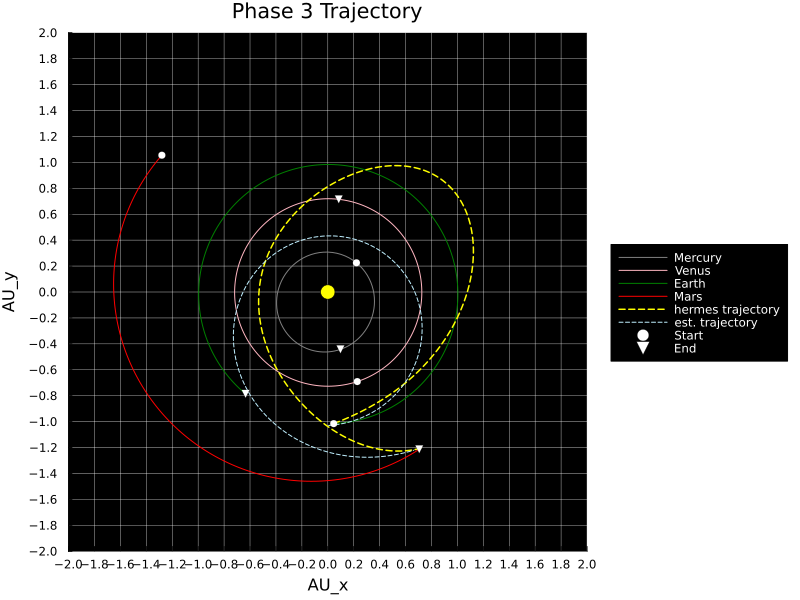

In [24]:
GraphPhase(xPhase3, "Phase 3 Trajectory",startSol,phaseTotal,false)

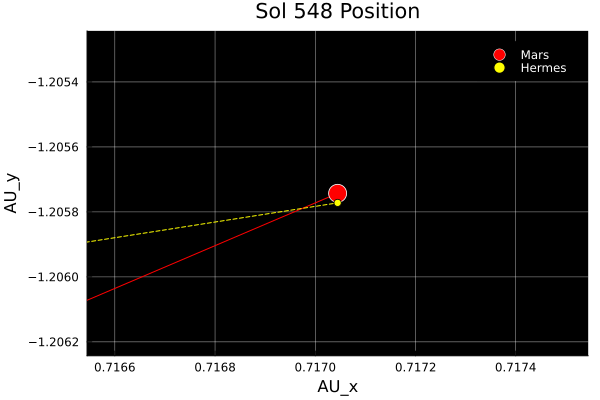

In [25]:
CloseUp(xPhase3, "Mars",startSol,phaseTotal,.0005)

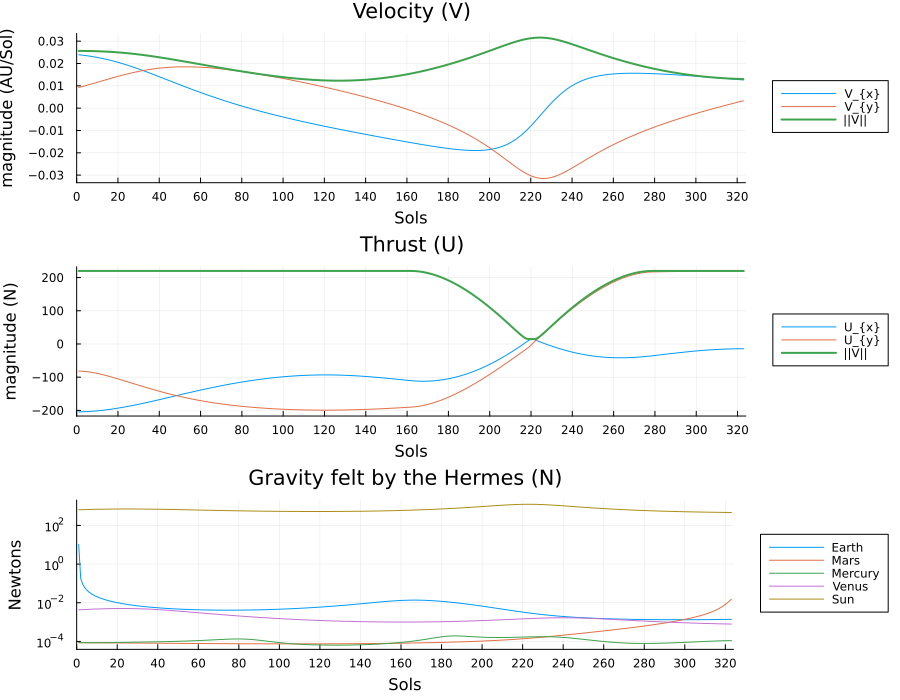

In [26]:
GetMetrics(xPhase3,vPhase3,uPhase3)

# 4. Results and Discussion 
Below is are the trajectory and metrics of the Hermes for the entire mission:

In [27]:
trajectory = vcat(xPhase1',xPhase3')'
velocity = vcat(vPhase1',vPhase3')'
thrust = vcat(uPhase1',uPhase3')'
total_t = length(thrust[1,:]) 
ga_time = 225;

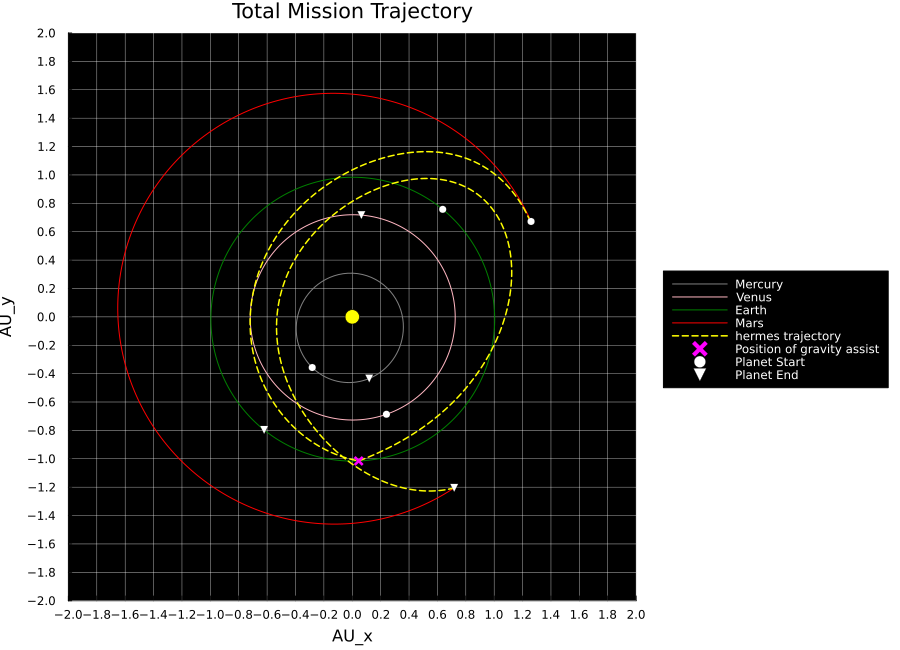

In [28]:
step = phaseTotal + 1
interval = 1:step
startPosit=cat(Vector(mercuryData[1,:]),Vector(venusData[1,:]),Vector(earthData[1,:]),Vector(marsData[1,:]),dims=2)
endPosit=cat(Vector(mercuryData[step,:]),Vector(venusData[step,:]),Vector(earthData[step,:]),Vector(marsData[step,:]),dims=2)

X = scatter([sunPos[1]],[sunPos[2]],mc=:yellow,ms=8,label=nothing,markerstrokewidth = .5)  
xaxis = Plots.get_axis(Plots.get_subplot(X,1),:x); xaxis[:gridalpha] = 0.7
yaxis = Plots.get_axis(Plots.get_subplot(X,1),:y); yaxis[:gridalpha] = 0.7
xaxis[:foreground_color_grid] = colorant"white"
yaxis[:foreground_color_grid] = colorant"white"
plot!(X, mercuryData[interval,1],mercuryData[interval,2],label="Mercury",linecolor=:grey)
plot!(X, venusData[interval,1],venusData[interval,2],label="Venus",linecolor=:lightpink) 
plot!(X, earthData[interval,1],earthData[interval,2],label="Earth",linecolor=:green) 
plot!(X, marsData[interval,1],marsData[interval,2],label="Mars",linecolor=:red)  
plot!(trajectory[1,:],trajectory[2,:],label="hermes trajectory",linestyle=:dash,linewidth=1.5,linecolor=:yellow)  
plot!(X, xticks=-2:.2:2,yticks=-2:.2:2,xlim=[-2,2],ylim=[-2,2],xlabel="AU_x",ylabel="AU_y") 
scatter!(X, [trajectory[1,ga_time]],[trajectory[2,ga_time]],ms=4,mc=:magenta,label="Position of gravity assist",markershape=:x,
markerstrokecolor=:magenta,markerstrokewidth=2)
scatter!(X, startPosit[1,:],startPosit[2,:],mc=:white,ms=4,markerstrokewidth = .1,label="Planet Start")
scatter!(X, endPosit[1,:],endPosit[2,:],mc=:white,ms=4,markerstrokewidth = .1,markershape=:dtriangle,label="Planet End") 
plot!(X, markerstrokecolor=:white,legendfontcolor=:white, legend=:outerright,size=(900,650),aspect_ratio=:equal, 
background_color=:black,background_color_outside=:white,title="Total Mission Trajectory") 

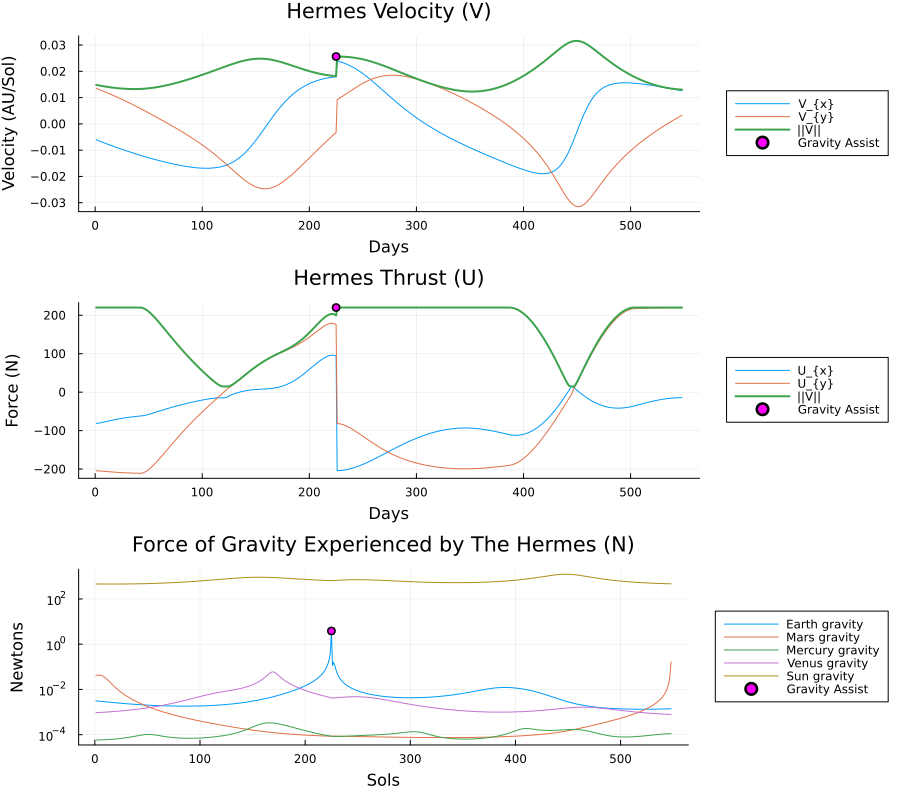

In [29]:
velocity = vcat(vPhase1',vPhase3')'

total_velocity = Vector()
for i in 1:length(velocity[1,:])
    tv = (velocity[1,i]^2 + velocity[2,i]^2)^.5
    append!(total_velocity,tv) 
end
V = plot(velocity[1,:],label="V_{x}",xlabel="Days",ylabel="Velocity (AU/Sol)",title="Hermes Velocity (V)")#,
         #xlim=(startSol-1,step+1),xticks=startSol:10:step,yticks=-.03:.005:.03)
plot!(V, velocity[2,:],label="V_{y}") 
plot!(V, total_velocity,label="||V||",linewidth=2) 
scatter!(V,[ga_time], [total_velocity[ga_time+1,:]],label="Gravity Assist",mc=:magenta)
thrust = vcat(uPhase1',uPhase3')'
total_thrust = Vector()
for i in 1:length(thrust[1,:])
    tt = (thrust[1,i]^2 + thrust[2,i]^2)^.5
    append!(total_thrust,tt) 
end
U = plot(thrust[1,:],label="U_{x}",xlabel="Days",ylabel="Force (N)",title="Hermes Thrust (U)")
plot!(U, thrust[2,:],label="U_{y}") 
plot!(U, total_thrust,label="||V||",linewidth=2)   
scatter!(U,[ga_time], [total_thrust[ga_time+1,:]],label="Gravity Assist",mc=:magenta)

x = vcat(xPhase1',xPhase3')'
X = plot(collect(1:total_t),
(earthMass*hermesMass*G*1*((-x[1,:] + earthData[1:total_t,1]).^2 + (-x[2,:] + earthData[1:total_t,2]).^2).^-.5),
yscale=:log10,label="Earth gravity")
plot!(collect(1:total_t),
(marsMass*hermesMass*G*1*((-x[1,:] + marsData[1:total_t,1]).^2 + (-x[2,:] + marsData[1:total_t,2]).^2).^-.5),
yscale=:log10,label="Mars gravity")
plot!(collect(1:total_t),
(mercuryMass*hermesMass*G*1*((-x[1,:] + mercuryData[1:total_t,1]).^2 + (-x[2,:] + mercuryData[1:total_t,2]).^2).^-.5),
yscale=:log10,label="Mercury gravity")
plot!(collect(1:total_t),
(venusMass*hermesMass*G*1*((-x[1,:] + venusData[1:total_t,1]).^2 + (-x[2,:] + venusData[1:total_t,2]).^2).^-.5),
yscale=:log10,label="Venus gravity")
plot!(X, collect(1:total_t),
(sunMass*hermesMass*G*1*((sunPos[1] .- x[1,1:total_t]).^2 + (sunPos[2] .- x[2,1:total_t]).^2).^-.5),
yscale=:log10,label="Sun gravity")
plot!(X, yticks=yticks=10 .^ (-8.:2:8),legend=:topleft,
  ylabel="Newtons",xlabel="Sols",title="Force of Gravity Experienced by The Hermes (N)",size=(1000,500))  
scatter!(X,[ga_time],[(earthMass*hermesMass*G*1*((-x[1,ga_time] + earthData[ga_time,1]).^2 + (-x[2,ga_time] + earthData[ga_time,2]).^2).^-.5)],label="Gravity Assist",mc=:magenta)
plot(V, U, X, layout=(3,1), legend=:outerright,size=(900, 800))



We can reach Mars with a relative velocity of 8.66 km/s, considering Mars' own velocity, and at a distance of 998 km from the planet's surface. In our trajectory plot, a constraint is imposed on the Hermes to decelerate to 5 km/s relative to Mars. However, this constraint leads the Hermes to crash into the surface of Mars. Despite this flaw, implementing the constraint encourages the model to favor a second gravity assist after the initial one, as illustrated in the appendix. It's worth noting that we reach Mars in 548 Sols, one Sol less than indicated in the plot (549 Sols). <br><br>
**Phase 1** <br>
The trajectory in Phase 1 closely aligns with the linear interpolation derived. The final velocity of the Hermes is 31.54 km/s. It is essential to define a constraint that positions the Hermes below and to the left of Earth, ensuring the gravity assist is performed in the correct direction.

**Phase 2** <br>
With a chosen angle of 49 degrees, we are able to increase the velocity from 31.54 km/s to 44.40 km/s. 

**Phase 3**  <br>
Achieving Mars with a relative velocity of 8.66 km/s is feasible. An alternative trajectory option is presented in the Appendix. While optimizing the trajectory, one of the models identified the potential benefit of a second gravity assist around Earth to reach Mars. However, this option was not selected as it brought the spacecraft too close to Mars. This decision is likely influenced by the increased tolerance programmed into the model to ensure an optimal solution within a reasonable timeframe, considering computing constraints.

# 5. Conclusion  #
*The Martian* author Andy Weir has acknowledged that his estimated path is not optimal, and there are likely other viable solutions. Our model was able to reduce the mission time by just one day. Given the non-convex nature of the problem, it is highly probable that more optimal trajectories exist. It's important to note that this model is a rough estimate and may not fully represent the complexity of the actual problem. Enhancements such as accounting for changes in mass due to fuel consumption and refining the time step could improve the model's accuracy and better replicate real-world scenarios. Despite its imperfections, like all optimization models, it serves as a stepping stone toward meeting the challenges of rescuing a stranded astronaut on the Red Planet.

# 6. Citations #
https://www.insidescience.org/news/inside-spaceflight-martian#:~:text=The%20Hermes%20would%20scream%20by,with%20a%20rocket%20containing%20Watney. <br>
https://www.facebook.com/462962073803090/photos/a.463868883712409.1073741828.462962073803090/682817308484231/ <br> 
https://docs.poliastro.space/en/stable/examples/Natural%20and%20artificial%20perturbations.html <br>
http://www.galactanet.com/martian/hermes.mp4 <br> 
https://archive.briankoberlein.com/2015/10/06/the-science-behind-the-martian-hermes-spacecraft/index.html <br> 
https://ssd.jpl.nasa.gov/horizons/app.html#/  <br>
https://excursionset.com/blog/2015/10/5/sciencing-the-martian <br> 
https://nbviewer.org/urls/laurentlessard.com/teaching/cs524/project/Spring2016/ScottPatenaude.ipynb

**gravity assist**  <br>
https://physics.stackexchange.com/questions/154854/maths-behind-gravity-assist  
<br><br> 

# 7. Appendix #

##### Trajectory Option 2: 2nd Gravity Assist.

In [30]:
#++++++ NEW PARAMETERS ++++++# 
startSol = 225 
interV = 12
dt = interV/12

kmPerAU = 149597871  
velConv = 1731.46 #km/s per AU/day 
marsRad = 3390 #km
startData = Int64(startSol * 12)
mercuryData3 = Matrix(mercury_raw[startData:interV:end,["X","Y"]])
venusData3 = Matrix(venus_raw[startData:interV:end,["X","Y"]])
earthData3 = Matrix(earth_raw[startData:interV:end,["X","Y"]])
marsData3 = Matrix(mars_raw[startData:interV:end,["X","Y"]]) 

PhaseLength = 323     
phaseTotal = startSol + PhaseLength - 1
minSun = 0.2 
maxSun = 1.5
step = Int64(round(PhaseLength/dt))
Tmax = 220 
marsFinVel = marsData3[step,:] - marsData3[step-1,:] #mars final velocity
λ = 100 
μ = 10 

maxRelFinV = .005 #Maximum relative final velocity difference for the Hermes and Mars in AU/Sol, 8.67 km/s

#++++++ SET ESTIMATED NONLINEAR TRAJECTORY ++++++#
offSet = gaEndPos + [-.1 1]'  #moves the trajectory in the right position relative to earth and mars
initLinearPos3 = zeros(2,step)
initLinearVel3 = zeros(2,step) 
β = 1.8

for i in 1:step 
    factor = (i/step)^β    
    initLinearPos3[:,i] = (earthData3[i,1:2]'.*(1-factor))+ (marsData3[i,1:2]'.*factor) .+ offSet' 
end 

for i in 1:step-1
    initLinearVel3[:,i] = (initLinearPos3[:,i+1]-initLinearPos3[:,i])*dt
end

In [31]:
m = Model(Ipopt.Optimizer)  
set_optimizer_attributes(m,"max_cpu_time" => 90.0, "print_level" => 3, "max_iter" => 8000,"tol" => .1)
μ = 100

#++++++ DEFINE VARIABLES FOR PROBE POSITIONS, VELOCITIES, AND THRUSTS ++++++#
@variable(m, HX[1:2,1:step])
@variable(m, HV[1:2,1:step])
@variable(m, HU[1:2,1:step]) 

destData3 = marsData3

for i in 1:2 
    for j in 1:step
        set_start_value(HX[i,j], initLinearPos3[i,j])
        set_start_value(HV[i,j], initLinearVel3[i,j]) 
    end
end; 

In [32]:
for i in 1:step-1
    #++++++ CURRENT POS IS PREV. POSITION + PREV. VELOCITY ++++++#
    @constraint(m, HX[:,i+1] .== HX[:,i] + dt*HV[:,i])
    
    #++++++ CURRENT VELOCITY IS PREV. + THRUST + GRAVITY ++++++#
    @NLconstraint(m, HV[1,i+1] == HV[1,i] + dt*α*(HU[1,i]/hermesMass + 
        sunMass*G*(sunPos[1] - HX[1,i])/((HX[1,i] - sunPos[1])^2 + (HX[2,i] - sunPos[2])^2)^1.5 +
        mercuryMass*G*(mercuryData3[i,1] - HX[1,i])/((HX[1,i] - mercuryData3[i,1])^2 + 
            (HX[2,i] - mercuryData3[i,2])^2)^1.5 +
        venusMass*G*(venusData3[i,1] - HX[1,i])/((HX[1,i] - venusData3[i,1])^2 + (HX[2,i] - venusData3[i,2])^2)^1.5 +
        earthMass*G*(earthData3[i,1] - HX[1,i])/((HX[1,i] - earthData3[i,1])^2 + (HX[2,i] - earthData3[i,2])^2)^1.5 +
        marsMass*G*(marsData3[i,1] - HX[1,i])/((HX[1,i] - marsData3[i,1])^2 + (HX[2,i] - marsData3[i,2])^2)^1.5))# +
    @NLconstraint(m, HV[2,i+1] == HV[2,i] + dt*α*(HU[2,i]/hermesMass + 
        sunMass*G*(sunPos[2] - HX[2,i])/((HX[1,i] - sunPos[1])^2 + (HX[2,i] - sunPos[2])^2)^1.5 + 
        mercuryMass*G*(mercuryData3[i,2] - HX[2,i])/((HX[1,i] - mercuryData3[i,1])^2 + 
            (HX[2,i] - mercuryData3[i,2])^2)^1.5 + 
        venusMass*G*(venusData3[i,2] - HX[2,i])/((HX[1,i] - venusData3[i,1])^2 + (HX[2,i] - venusData3[i,2])^2)^1.5 +
        earthMass*G*(earthData3[i,2] - HX[2,i])/((HX[1,i] - earthData3[i,1])^2 + (HX[2,i] - earthData3[i,2])^2)^1.5 +
        marsMass*G*(marsData3[i,2] - HX[2,i])/((HX[1,i] - marsData3[i,1])^2 + (HX[2,i] - marsData3[i,2])^2)^1.5))
end

#++++++ KEEP THRUST BELOW CERTAIN VALUE ++++++#
@constraint(m, Tmax .<= (HU[1,:].^2+HU[2,:].^2) .<= Tmax^2)

#++++++ INITIAL CONSTRAINTS FOR HERMES ++++++#
@constraint(m, HX[:,1] .== gaEndPos[:])
@constraint(m, HV[:,1] .== gaEndVel[:])   

#++++++ RENDEZVOUS CONSTRAINTS FOR HERMES ++++++#
@constraint(m,(HX[1,step]-marsData3[step,1])^2 + (HX[2,step]-marsData3[step,2])^2 <= .00005^2) #bring hermes relatively close to mars
@constraint(m, HX[1, step] <= destData3[step,1]) 
@constraint(m, HX[2,step] <= destData3[step,2] - (1000/149597871)) 


#velocity contraints 
@constraint(m, (HV[:,step] - marsVel[:]).^2 .<= .005^2)  #.005 experiences two gravity assists

#++++++ MIN DISTANCE FROM SUN ++++++# 
@constraint(m, HX[1,:].^2 + HX[2,:].^2 .>= minSun)   

#++++++ CANNOT LEAVE INNER SOLAR SYSTEM ++++++#
@constraint(m,-1.5 .<= HX .<= 1.5) 

@objective(m, Min, λ*sum((HU[1,1:step-1]-HU[1,2:step]).^2 + (HU[2,1:step-1]-HU[2,2:step]).^2) 
    + μ*sum((HX[:,2:step] - HX[:,1:step-1]).^2)
)

    
@time(optimize!(m))   
println() 
println(termination_status(m)) 

xPhase3 = value.(HX)
vPhase3 = value.(HV)
uPhase3 = value.(HU) 
xEnd3 = xPhase3[:,step] 
vEnd3 = vPhase3[:,step]
uEnd3 = uPhase3[:,step];

Total number of variables............................:     1938
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1292
Total number of inequality constraints...............:     2266
        inequality constraints with only lower bounds:     1292
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      974


Number of Iterations....: 903

                                   (scaled)                 (unscaled)
Objective...............:   1.7474481255110900e+05    1.7474481255110900e+05
Dual infeasibility......:   2.3725633897797582e-07    2.3725633897797582e-07
Constraint violation....:   2.0365653607967715e-15    2.0365653607967715e-15
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementar

In [33]:
marsVel = marsData3[step,:] - marsData3[step-1,:]; #Mars final velocity phase 1 
marsPos = marsData3[step,:] 
marsHermRelVel = [(vEnd3[1] - marsVel[1]) * 1731.46, (vEnd3[2] - marsVel[2]) * 1731.46]  
relVelScalar = sqrt(dot(marsHermRelVel, marsHermRelVel'))
relDist = (marsPos - xEnd3) * kmPerAU 
relDistScalar = sqrt(dot(relDist,relDist')) - marsRad
println("Distance between the Hermes and Mars' Surface: ", round.(relDistScalar,digits=2), " km") 
println()
println("Hermes' velocity relative to Mars: ", round.(relVelScalar,digits=5), " km/s") 

Distance between the Hermes and Mars' Surface: -2391.8 km

Hermes' velocity relative to Mars: 8.71206 km/s


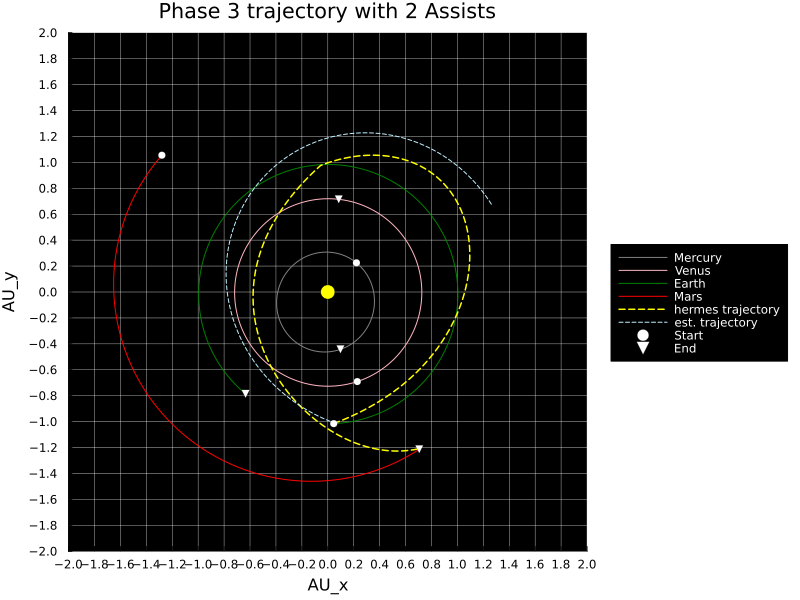

In [34]:
GraphPhase(xPhase3, "Phase 3 trajectory with 2 Assists")

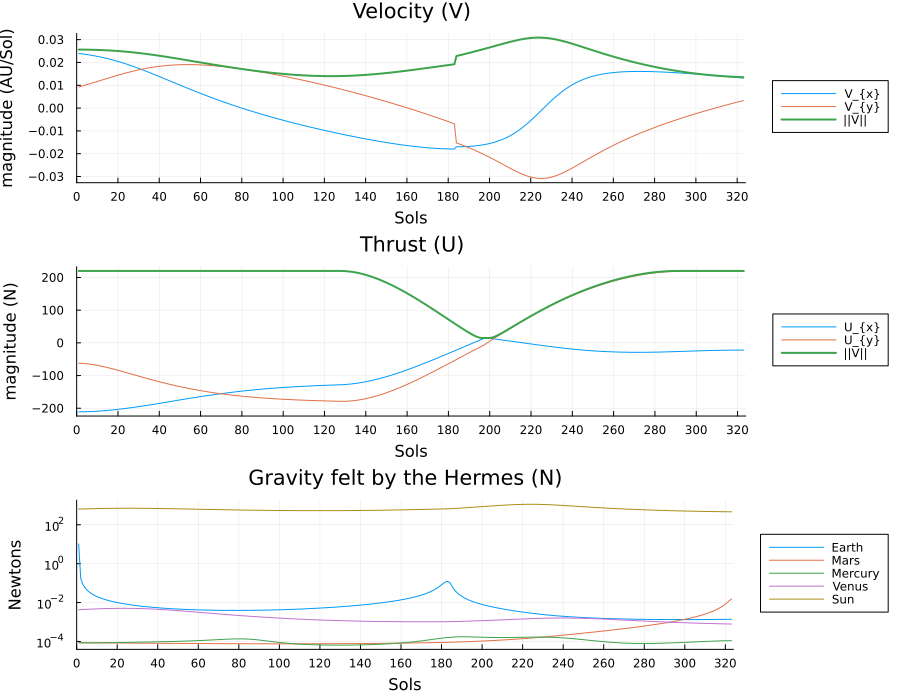

In [37]:
GetMetrics(xPhase3, vPhase3, uPhase3)

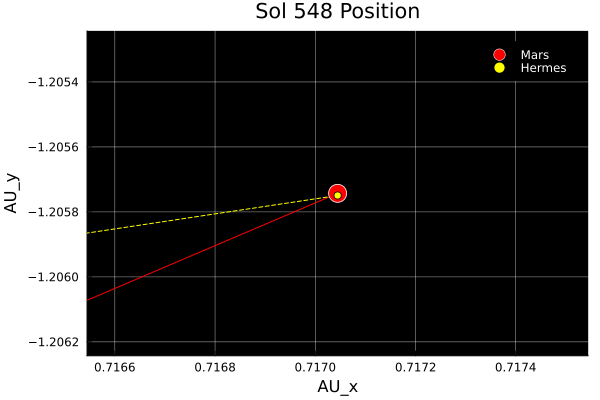

In [36]:
CloseUp(xPhase3,"Mars",startSol,step,.0005)